In [1]:
#Importing libraries
import astropy.io.fits as pf
import numpy as np
import os
import math as mt
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import scipy.stats as st
from stingray import Lightcurve
import statistics
from scipy.stats import chi2
import itertools
from plotly.subplots import make_subplots
import plotly.graph_objects as go

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


# Make pulse profile matrix

## Retrieving data

In [2]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Segmenting the data 

In [3]:
# We separate the data into 20 segments 

#We change the number of events we use 
#so that it can be divided by 20
size=1387000

#Getting corresponding sizes of bins
seg_size = int(size/20)

#Making lists that will contain the 20 segments of time and PI data
#We extract the PI data to get the periodogram for each segment.
Time_segments = []
PI_segments = []

#Populating the time and PI segment lists
for i in range(20):
    Time_segments.append(Time_phase_data['TIME'][seg_size*i:seg_size*(i+1)])
    PI_segments.append(Time_phase_data['PI'][seg_size*i:seg_size*(i+1)])


## Getting the periodogram for each segment

"for i in range(20):\n    new_axs[i].loglog(freq_segments[i], Power_segments[i], '.')\nnew_axs[17].set_xlabel('Frequency')\nnew_axs[5].set_ylabel('Lomb-Scargle Power')\nnew_axs[2].set_title('Periodogram')\nplt.show()"

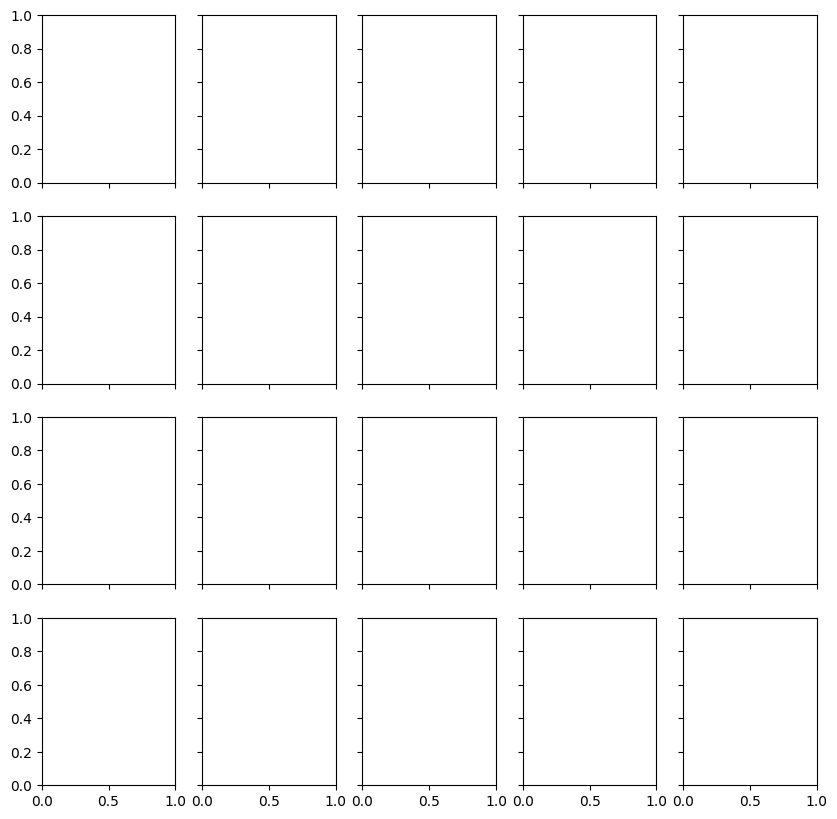

In [4]:
#Getting the periodogram for each of them 

new_f, ((new_ax1, new_ax2, new_ax3, new_ax4, new_ax5), (new_ax6, new_ax7, new_ax8, new_ax9, new_ax10), 
        (new_ax11, new_ax12, new_ax13, new_ax14, new_ax15),
        (new_ax16, new_ax17, new_ax18, new_ax19, new_ax20))= plt.subplots(4, 5, sharex=True, figsize=(10, 10), sharey=True)
new_axs = [new_ax1,new_ax2,new_ax3,new_ax4,new_ax5,new_ax6,new_ax7,new_ax8,new_ax9,new_ax10,new_ax11
       ,new_ax12,new_ax13,new_ax14,new_ax15,new_ax16,new_ax17,new_ax18,new_ax19,new_ax20]

#Populating the power and frequency lists
def get_power_and_freq(time_segments, energy_segments, n):
    freq_segments=[]
    Power_segments=[]
    for i in range(n):
        freq_temp, power_temp = LombScargle(time_segments[i], energy_segments[i]).autopower()
        freq_segments.append(freq_temp)
        Power_segments.append(power_temp)   
    return freq_segments, Power_segments

freq_segments, Power_segments = get_power_and_freq(Time_segments, PI_segments, 20)
    
#Plotting the peridogram for each segment (not aboslutely necessary)
'''for i in range(20):
    new_axs[i].loglog(freq_segments[i], Power_segments[i], '.')
new_axs[17].set_xlabel('Frequency')
new_axs[5].set_ylabel('Lomb-Scargle Power')
new_axs[2].set_title('Periodogram')
plt.show()'''

## Getting the first harmonic frequency for each segment and fitting a linear regression

In [6]:
#Extracting the first harmonic for each segment

#Making a function to get the first harmonic frequencies for each segment
#We will then fit a polynomial to these frequencies to make an accurate epoch_folding function

#ref_time: reference time we will use to populate the bins list
#time_segments: times for the different segments
#freq_segments: the various frequencies given by the Lomb Scargle Periodogram
#power_segments: the power values corresponding to each frequency in the Peridogram

def Harmonic_funk(order_fit, limit, ref_time, time_segments, freq_segments, power_segments):
    
    #Making the harmonic frequency list and a bin list that we 
    #will use to plot the frequencies and fit a linear regression. 
    #We fill the bin list with the average time per segment SINCE the 
    #start of observations. This is so that the regression 
    #can be used later for folding our time lists.
    Harmonic=[]
    bins = []
    
    #Populating the Harmonic and bins lists 
    for i in range(20):
    #See above for explanation of what we put in bins list
        bins.append(np.mean(time_segments[i]-ref_time))
    
    #Cutting off frequencies (and power associated) 
    #that are due to red noise (low frequencies)
        temp_1 = freq_segments[i] > limit
    
    #Getting the cut-off frequencies and powers
        temp_2 = freq_segments[i][temp_1]
        temp_3 = power_segments[i][temp_1]
    
    #Getting the harmonic frequency 
        temp_freq_max = temp_2[np.argmax(temp_3)]
        Harmonic.append(temp_freq_max)
    #Get regression coefficients.
    reg = np.polyfit(bins, Harmonic,order_fit)
    #We plot the Harmonic frequencies as a function of the average time
    #of segments with respect to start time of observations.
    plt.plot(bins, Harmonic, '.', label='Measured Harmonic freq.')
    
    #Getting modelled harmonic values
    new_Harmonics=[]
    predict=np.poly1d(reg)
    for i in bins:
        new_Harmonics.append(predict(i))
    
    #Plot modelled harmonics on top of the observed ones.
    plt.plot(bins, new_Harmonics, '.', label='Expected Harmonic freq. (Lin.Reg.)')
    plt.xlabel('Segment number')
    plt.ylabel('Main Hamornic Frequency (Hz)')
    plt.legend()
    return reg, bins

regr, bins = Harmonic_funk(3, 0.01, Time_phase_data['TIME'][0], Time_segments, freq_segments, Power_segments)


NameError: name 'freq_segments' is not defined

In [5]:
print(reg)

NameError: name 'reg' is not defined

## Plotting the pulse profile matrix and a first-order sinusoidal model


35
30
32
28
30
40
33
29
32
26
32
31
36
26
30
31
29
25
34
26


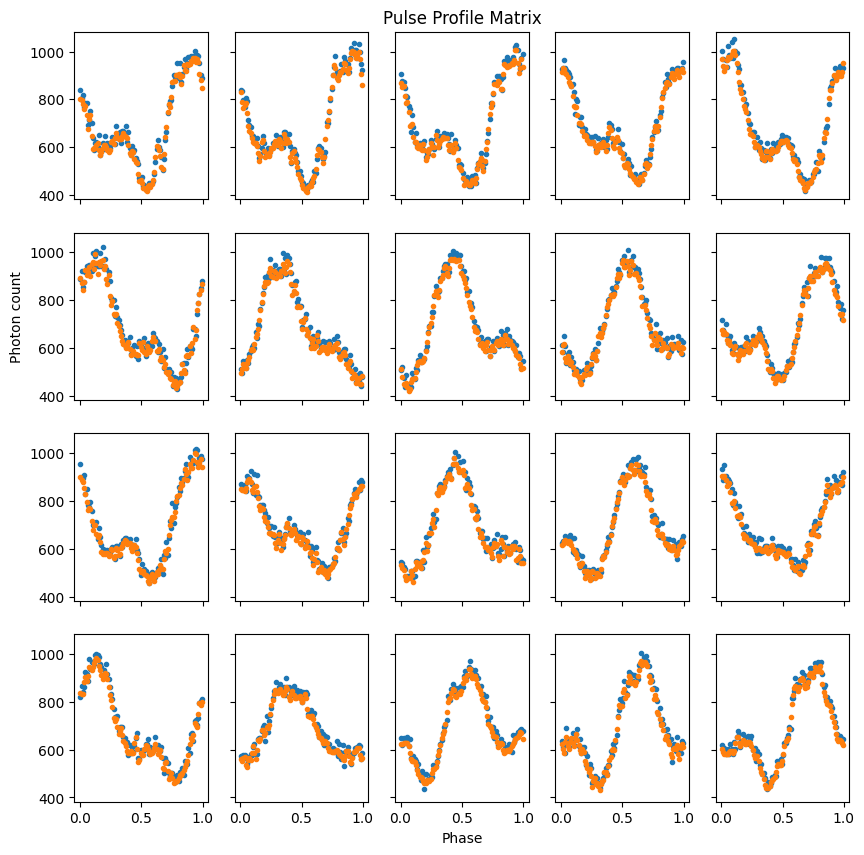

In [322]:
#Defining an epoch folding function to plot the phase folded 
#pulse profiles

def phase_fold(ref_time, time_array, coeffs):
    
    if len(coeffs)==1:
        A = (time_array - ref_time)*coeffs[0]
        return A%1
    else:
        A = (time_array - ref_time)*coeffs[-1]
        for i in range(2, len(coeffs)+1):
            A+=(1/mt.factorial(i))*coeffs[-i]*(time_array - ref_time)**i
        phasefold_time = A%1
    return phasefold_time

def chisquared(model, expec, uncertainty):
    Xi=0
    for i in range(len(model)):
        Xi+=((model[i]-expec[i])/uncertainty[i])**2
    return Xi

#Defining a function to model the pulse period 
#with an n-order sinusoidal function
def model_pulse(order, time, counts):
    
    #Fourier transform the pulse profiles
    counts_fft = np.fft.rfft(counts)
    
    #Get the phase and amplitudes from Fourier transformed pulse profiles
    phases = np.arctan2(counts_fft.imag, counts_fft.real)
    amplitudes = np.sqrt(counts_fft.imag**2 + counts_fft.real**2)
    
    
    #Getting the sinusoidal model
    base_phi = 2*np.pi*time
    A = 0.5*counts_fft.real[0]
    for i in range(order):
        A+=amplitudes[i+1]*np.cos((i+1)*base_phi + phases[i+1])
        
    #Normalizing it
    A = A/len(counts_fft)
    return A, phases

#order: order of the sinusoidal model to use
#segments: the different time segments of data we will use to make each plot
#ref_data: datat that can be used to get the reference time
#reg: LINEAR regression coefficients to use for epoch folding

def pulse_profile_matrix(segments, ref_time, reg_coeffs, special_case, dt=0.01):
    #Making a function to calculate the order of sinusoidal function to use
    #for the model to overplot on pulse profile of segments. We do this using chisquared
    def find_optimal_order(counts, time):
        n=0
        failsafe=[]
        std = [np.sqrt(j) for j in counts]
        #Go through possible values of order and compute the chisquared for each of them
        #Stop once the chisquared has reached <0.001.
        for i in range(1,int(len(counts)/2)):
            model = model_pulse(i, time, counts)[0]
            #We need to normalize our model and expected values for the chisquared function
            #to work properly
            free_deg = 1 + 2*i
            chisq=chisquared(model, counts, std)
            failsafe.append(chi2.sf(chisq, free_deg))
            if chi2.sf(chisq, free_deg) > .1:
                n=i
                break
        if n==0:
            n=failsafe.index(np.max(failsafe))
        return n
    
    #Create array that will contain the phase value of 
    #1st harmonic for each segment 
    phases = []

    #Create figure variables
    if not special_case:
        f, ((ax1, ax2, ax3, ax4, ax5), 
    (ax6, ax7, ax8, ax9, ax10), 
    (ax11, ax12, ax13, ax14, ax15), 
    (ax16, ax17, ax18, ax19, ax20)) = plt.subplots(4, 5, sharex=True, figsize=(10, 10), sharey=True)
        axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,
       ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20] 
    
    #Making a list that will contain the orders of sinusoidal model used for each segment 
    orders=[]
    
    #Making the pulse profile for each segment 
    #and overplotting a first-order sinusoidal model
    #using the phase of first harmonics of each segment.
    
    if not special_case:
        for i in range(20):
        
        #Computing the phase folded time
            test_phase_fold = phase_fold(ref_time, segments[i], reg_coeffs)

    #Making the lightcurve using the phase folded time
            test_lc = Lightcurve.make_lightcurve(test_phase_fold, dt)
    #Finding order of model to use
    
            order=find_optimal_order(test_lc.counts, test_lc.time)
            orders.append(order)
            print(order)
    #Create n-order sinusoidal model using the phase of first harmonics
            model, model_phase = model_pulse(order, test_lc.time, test_lc.counts)

    #Make a list containing the phases for future use - i.e. regression
            phases.append(model_phase)

    #Plot the pulse profile and the cosine obtained from phase of first harmonic frequency
            axs[i].plot(test_lc.time, test_lc.counts, '.')
            axs[i].plot(test_lc.time, model, '.')
        axs[2].set_title('Pulse Profile Matrix')
        axs[5].set_ylabel('Photon count')
        axs[17].set_xlabel('Phase')
    else:
        for i in range(2):
        
        #Computing the phase folded time
            test_phase_fold = phase_fold(ref_time, segments[i], reg_coeffs)

    #Making the lightcurve using the phase folded time
            test_lc = Lightcurve.make_lightcurve(test_phase_fold, dt)
    #Finding order of model to use
    
            order=find_optimal_order(test_lc.counts, test_lc.time)
            orders.append(order)
            print(order)
    #Create n-order sinusoidal model using the phase of first harmonics
            model, model_phase = model_pulse(order, test_lc.time, test_lc.counts)

    #Make a list containing the phases for future use - i.e. regression
            phases.append(model_phase)

    #Plot the pulse profile and the cosine obtained from phase of first harmonic frequency
            plt.plot(test_lc.time, test_lc.counts, '.')
            plt.plot(test_lc.time, model, '.')
            plt.show()
    return orders, phases

orders, phases = pulse_profile_matrix(Time_segments, Time_phase_data['TIME'][0], regr, False)


## Plotting the phases used for the model to refine our epoch folding function

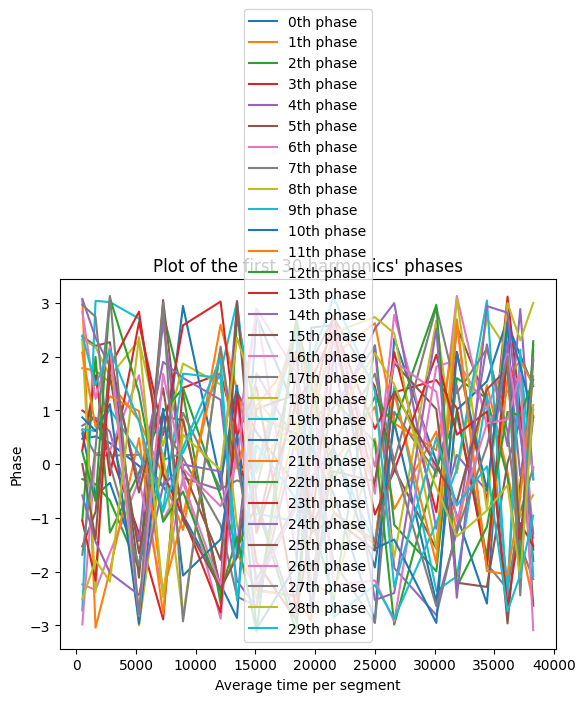

In [228]:
#We use the previously defined bins list to plot 
#the phases for in terms of average time in each segment

#order: order of the sinusoidal model used i.e. how many harmonics were actually used
#xdata: data to use for plotting against the phases. By convention we use the average time per segment
#with respect to the start time
#phase_list: List containing sub-lists of ALL the phases for each segment
#will require some manipulation to extract only the useful phases -> Done below
def Plot_phases(order, xdata, phase_list):
    
    relevant_phases=[]
    temp=[]
    
    #We make a small double nested for loop to extract the phases
    #we actually used to make our model
    
    for i in range(order):
        for j in range(len(phase_list)):
        #Don't forget to increment by one the phase we extract
        #because the first value in each list of phases is always 0
            temp.append(phase_list[j][i+1])
        relevant_phases.append(temp)
        temp=[]
    
    #Make n plots for the n phases used in our n-order sinusoidal model 
    for i in range(order):
        plt.plot(xdata, relevant_phases[i], '.', label=str(i)+'th phase')
        plt.ylabel('Phase')
        plt.xlabel('Average time per segment')
        plt.title('Plot of the first '+str(order)+' harmonics\' phases')
        plt.legend()
    plt.show()
    return 

Plot_phases(statistics.mode(orders), bins, phases)

## Testing out what we have so far on an energy pulse profile

In [328]:
print(min(Time_phase_file[1].data['PI']), max(Time_phase_file[1].data['PI']))
energy_max=4093
#Getting sizes of bins
energy_lim = 4080/2
#Making lists that will contain the 20 segments of time and PI data
energy_time_segments = []
energy_time_segment = []
energy_segments = []
energy_segment = []
#Populating the time and PI segment lists
for i in range(2):
    for j in range(len(Time_phase_file[1].data['PI'])):
        if energy_lim*i < Time_phase_file[1].data['PI'][j] < energy_lim*(i+1):
            energy_segment.append(Time_phase_file[1].data['PI'][j]*40)
            energy_time_segment.append(Time_phase_file[1].data['TIME'][j])
    energy_segments.append(energy_segment)
    energy_segment=[]
    energy_time_segments.append(energy_time_segment)
    energy_time_segment=[]

0 4093


255


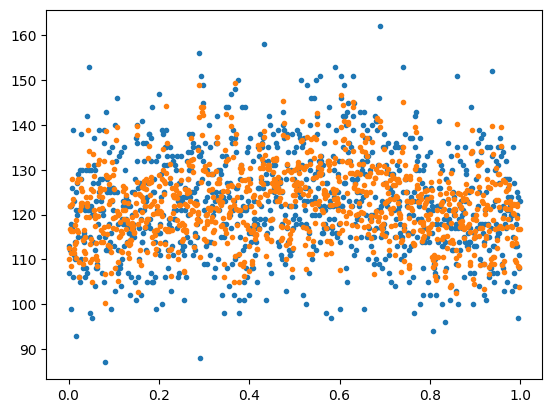

249


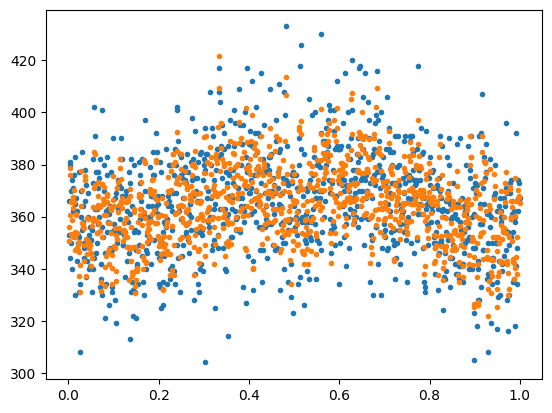

In [324]:
#energy_freq_segments, energy_power_segments = get_power_and_freq(energy_time_segments, energy_segments, 2)

energy_orders, energy_phases = pulse_profile_matrix(energy_time_segments, Time_phase_data['TIME'][0], [0.2082182182182182], True, 0.001)


